In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _single, _pair, _triple
from torch.nn.modules.conv import _ConvNd
import torch.nn.init as init
from torch.nn.init import calculate_gain, _calculate_correct_fan, _calculate_fan_in_and_fan_out
import import_ipynb

from Pars import Parseval

importing Jupyter notebook from Pars.ipynb


In [3]:
class _FilterBank(object):
    def __init__(self):

        self.frame = self.get_fb("frame", [(3, 3), (5, 5), (7, 7)])
        self.pframe = self.get_fb("pframe", [(3, 3), (5, 5), (7, 7)])
        self.nn_bank = self.get_fb("nn_bank", [(3, 3), (5, 5), (7, 7)])

    def get_fb(self, fbank_type, shapes):
        return {
            self.shape2str(item):
                np.float32(Parseval(
                    shape=item,
                    low_pass_kernel='gauss',
                    first_order=True,
                    second_order=True,
                    bank=fbank_type).fbank())
            for item in shapes
        }

    def shape2str(self, shape):
        return 'x'.join([f'{dim}' for dim in shape])


FilterBank = _FilterBank()

In [9]:
print(FilterBank.pframe['7x7'].shape)
print(type(FilterBank.frame['7x7']))

#print(sys.getrefcount(FilterBank))
#print(sys.getrefcount(FilterBank.nn_bank))


(79, 7, 7)
<class 'numpy.ndarray'>


In [14]:
def kaiming_uniform_mod(tensor, a=0, gain=1, mode='fan_in', nonlinearity='leaky_relu'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where
    .. math::
        \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}
    Also known as He initialization.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
            backwards pass.
        nonlinearity: the non-linear function (`nn.functional` name),
            recommended to use only with ``'relu'`` or ``'leaky_relu'`` (default).
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='relu')
    """
    gain_mod = gain  # The "gain_mod" mutiplier is my only modification
    fan = _calculate_correct_fan(tensor, mode)
    gain = calculate_gain(nonlinearity, a)
    std = (gain / math.sqrt(fan)) * gain_mod
    # print(gain, gain_mod)
    bound = math.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation
    with torch.no_grad():
        return tensor.uniform_(-bound, bound)

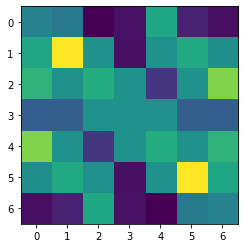